In [1]:
# Other modules are not supported during coursework marking.
# Other modules cannot be used unless a written approval is given.
from matplotlib import pyplot as plt
import numpy as np
# More information about skimage draw module can be found at 
# https://scikit-image.org/docs/stable/api/skimage.draw.html#skimage.draw.line
from skimage.draw import line, line_aa
from skimage.draw import circle_perimeter, circle_perimeter_aa

In [9]:
def my_segmentation(input_image):
    """Description:
    This function performs image segmentation by global thresholding.
    The segmentation results have three kinds of non-overlapping regions. 
    The segmentation results are represented by an image with three intensity levels, 10, 127 and 200. No pixel with other intensity levels.
    10, 127 and 200 represent pixels originally with low-intensity, mid-intensity and high-intensity values, respectively.  
    The global thresholds are estimated by using the Gaussian Mixture Model (GMM) and Expectation-Maximization (EM) method.
    The number of Gaussian distributions is three.
    The implementation of GMM and EM method follows the details given in the lecture notes and the tutorial.
    Intensity values outside the image region are assumed zero.

    Parameter: input_image = input array representing an image.
    
    Return:
    new_image = a segmented image with three kinds of non-overlapping regions. 
    Each region is represented by an intensity level.
    There are three intensity levels, 10, 127 and 200.
    Regions with intensity level 10 are pixels originally with low-intensity values.
    Regions with intensity level 127 are pixels originally with mid-intensity values.
    Regions with intensity level 200 are pixels originally with high-intensity values.
    

    Requirements:
    Pre-defined functions for estimating histogram, GMM and EM method cannot be used.
    Pre-defined functions for filtering, convolution, correlation cannot be used, e.g., filter2D.
    You must use double for-loop (nested for-loop) for accessing pixels in the input image.

    Marking criteria:
    The output image will be marked.
    No mark if any global threshold is hard coded. 
    No mark if the global thresholds are not estimated by using EM method and GMM. 
    No mark if the operation is not using EM method.
    No mark if the operation is not using GMM.
    No mark if the implementation does not follow details given the lecture notes and tutorial.
    Partial marking is possible.
    """

    # create a new image which is identical to input image
    H, W = input_image.shape
    new_image = np.zeros((H, W))

    ############################
    # [Your code goes here]
    ############################

    def my_image_smoothing(input_image):
        """Description:
        The same function
        """
        
        # create a new image which is identical to input image
        H, W = input_image.shape
        new_image = np.zeros((H, W))
    
        # creating cross-correlation kernel
        kernel = np.ones((3,3))*1/9

        # Access every individual pixel -> perform mean filter
        for i in range(1,H-1):
            for j in range(1,W-1):
                A = input_image[i-1:i+2 ,j-1:j+2].reshape(-1)
                new_image[i, j] = np.sum(A*kernel.reshape(-1))

        # # Renormalize to 0-255
        new_image = (new_image - np.min(new_image))/(np.max(new_image) - np.min(new_image))*255

        return new_image
    
    # input_image = smooth(input_image , kernel_size = 3)
    # input_image = my_image_smoothing(input_image)

    # parameters
    mu = np.array([30 , 120 , 220])
    mu_copy = mu.copy()
    sigma = np.array([10, 20, 10])
    w = np.array([1/3,1/3,1/3])

    max_iter = 20 # initialize iterations for EM algorithm
    
    # define a likelihood function
    def likelihood(x , mu, sigma):
        '''
        calculate likelihood of a point belonging to gaussian with params mu and sigma
        '''
        return np.exp(-(x - mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
    
    # conduct the EM algorithm
    for _ in range(max_iter):
        # create nd.array to house probabilities of each pixel's intensity, assuming they arise from the different gaussian distributions
        # Expectation step - calculate the posterior probabilities
        probs = np.zeros((H,W,3)) # first H*W matrix to represent mu1, sigma1. second to represent the second distribution
        for j in range(3):
            probs[:,:,j] = likelihood(input_image , mu[j] , sigma[j])*w[j]

        sum_probs = np.sum(probs , axis = 2)

        # Normalize - think of it as marginalizing out j
        for j in range(3):
            probs[:,:,j] = probs[:,:,j]/sum_probs

        # Maximization step - iteratively optimize mu, sigma and weight values
        for j in range(3):
            mu[j] = np.sum(probs[:,:,j]*input_image)/np.sum(probs[:,:,j])
            sigma[j] = np.sqrt(np.sum(probs[:,:,j]*(input_image - mu[j])**2)/np.sum(probs[:,:,j]))
            w[j] = np.sum(probs[:,:,j])/(H*W)
    print(f'this is sigma -> {sigma}')
    # Minimizing inter-class variance and maximizing intra-class variance
    # Ideal condition for threshold is reached when w1*p(T|1) = w2*p(T|2)
    Thresholds = np.ones(2)
    eps = [1e-6,5e-3] # init epsilon threshold for iteratively finding thresholds

    for j in range(len(Thresholds)):
        for threshold in range(mu_copy[j] , mu_copy[j+1]):
            # Check if w1*p(T|1) = w2*p(T|2) within a certain degree of tolerance epsilon
            diff = np.abs(w[j]*likelihood(threshold , mu = mu_copy[j] , sigma = sigma[j]) - w[j+1]*likelihood(threshold , mu = mu_copy[j+1] , sigma = sigma[j+1]))
            if diff < eps[j]:
                Thresholds[j] = threshold

    # print(Thresholds)
    # Fill image with discrete pixel intensity
    for i in range(H):
        for j in range(W):
            if input_image[i,j] < Thresholds[0]:
                new_image[i,j] = 10
            elif input_image[i,j] < Thresholds[1]:
                new_image[i,j] = 127
            else:
                new_image[i,j] = 200

    ############################
    # [Your code ends here]
    ############################

    return new_image

this is sigma -> [10 10 10]


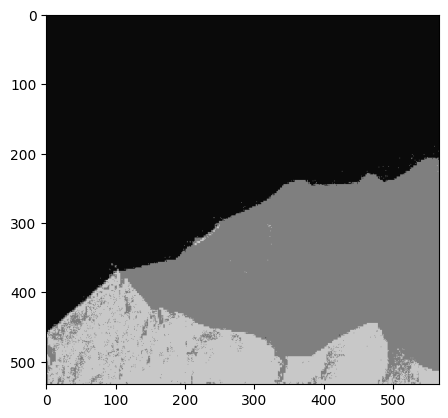

In [10]:
###############################################################################
# Q8: Image segmentation by global thresholding (12 marks)
###############################################################################
# read in a 2D image for testing, input_image is a 2D ndarray
# The image is obtained from ImageProcessingPlace.com, DIP3/e
input_image = plt.imread('Fig1045(a)(iceberg).tif')

plt.imshow(my_segmentation(input_image) , vmin = 0 , vmax = 255 , cmap = plt.cm.gray)

In [11]:
def my_circle_detection(input_image):
  """Description:
    This function extracts the round objects (including missing parts) in an image by using the Hough transform method.
    The number of round objects in the image is at least one.
    If more than one object, their intensity values may be different. The objects may touch. 
    The implementation follows the details given in the Line and Circle Detection lecture notes and the tutorial.
    Intensity values outside the image region are assumed zero.
    You can assume the round object diameter ranges from 188 pixels to 196 pixels.

    Parameter: input_image = input array representing an image.
    This image has at least one round object. Some round objects have missing parts.
    The image has been corrupted by random noise.

    Return: 
    new_image_circles = an original image with the round objects overlaid with the white detected circle(s) (intensity = 255).
    new_image_largest = an image shows the largest round object with its white detected circle. 
      Regions outside the white detected circle are removed (set to zero intensity value), and inside circle remain unchanged.
    new_image_sorted = an image shows all round objects (with their white detected circles) aligning horizontally in the middle of the image.
      The detected circles containing round objects are displaced to achieve horizontal alignment.
      The left-most circle contains the largest object and the right-most circle contains the smallest object.
      Regions outside the white detected circles are removed (set to zero intensity value), and inside circles remain unchanged.

    Requirements:
    Pre-defined functions for Hough transform cannot be used.
    Pre-defined functions for filtering, convolution, correlation cannot be used, e.g., filter2D.
    You must use double for-loop (nested for-loop) for accessing pixels in the input image.

    Marking criteria:
    The output images will be marked.
    No mark if the operation is not Hough transform.
    No mark if the implementation does not follow details given the lecture notes and tutorial.
    Mark deduction if image aliasing is observed.
    Partial marking is possible.
  """

  # create a new image which is identical to input image
  H, W = input_image.shape
  new_image_circles = np.zeros((H, W))
  new_image_largest = np.zeros((H, W))
  new_image_sorted = np.zeros((H, W))

  ############################
  # [Your code goes here]
  ############################

  def simple_threshold(input_image):
        '''
        returns simple thresholded image dividing circles and background up into two separate intensities
        params input_image -> image for which gradient magnitude is to be estimated
        '''
        H,W = input_image.shape
        new_image = np.zeros((H,W))
        # find threshold
        threshold = 0
        max_iter=20
        for _ in range(max_iter):
            m1 = np.mean(input_image[input_image > threshold])
            m2 = np.mean(input_image[input_image <= threshold])
            threshold = 0.5*(m1+m2)
        for i in range(H):
            for j in range(W):
                if input_image[i,j] > threshold:
                    new_image[i,j] = 255
                else:
                    new_image[i,j] = 0
        return new_image

  def grad_mag(input_image):
        '''
        returns gradient magnitude of image , returns gradient angle of image
        params input_image -> image for which gradient magnitude is to be estimated
        '''
        # sobel filters
        sobelx = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
        sobely = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        
        # create new blank image
        H , W = input_image.shape
        image_grad , image_angle = np.zeros((H,W)) , np.zeros((H,W))
        # convolve image
        for i in range(1 , H - 1):
            for j in range(1 , W - 1):
                A = input_image[i-1:i+2 , j-1:j+2]
                gx = np.sum(A*sobelx)
                gy = np.sum(A*sobely)
                image_grad[i,j] = np.sqrt(gx**2 + gy**2) #np.abs(gx) + np.abs(gy)
                image_angle[i,j] = np.arctan2(gy,gx)
        # Rescale
        image_grad = (image_grad - np.min(image_grad))/(np.max(image_grad) - np.min(image_grad))*255

        return image_grad , image_angle
      
  def nms(G , theta):    
        '''
        Resource: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
        returns non-maximal suppressed version of image
        params G -> gradient magnitude of image
        params theta -> gadient angle of image
        '''
        H,W = G.shape
        Z = np.zeros((H,W), dtype=np.int32) #init zero valued array of same shape
        angle = theta * 180/np.pi # convert to degree
        angle[angle < 0] += 180
                
        for i in range(1,H-1):
            for j in range(1,W-1):
                try:
                    # Assigning neighbouring pixels based on the gradient angle
                    #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        p = G[i, j+1]
                        r = G[i, j-1]
                    #angle 45/135
                    elif (22.5 <= angle[i,j] < 67.5) or (112.5 <= angle[i,j] < 157.5): # pedantically, p and r should flip for the 'OR' condition, but computationally it's the same
                        p = G[i+1, j-1]
                        r = G[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        p = G[i+1, j]
                        r = G[i-1, j]
                    if (G[i,j] >= p) and (G[i,j] >= r): # Is the middle pixel brighter than both its neighbours?
                        Z[i,j] = G[i,j]
                    else:
                        Z[i,j] = 0
                        
                except IndexError as e:
                    pass
        return Z

  def hough_transform_circle(input_img , intensity_threshold = 255 , points_threshold = 100):
        '''
        performs hough transform on edge image after non maximal suppression
        param input_img : image with edges obtained after applying edge detection
        param intensity_threshold : lines with at least this brightness should be consideted from the edge image
        '''
        b , a = input_img.shape
        diam = np.linspace(188,196,num=(196-188+1)) # get the specified diameters
        R = np.unique((diam/2).astype('int')) # get the radius

        # Theta range -> 0 to 360
        theta = np.linspace(0,360,num=(360-0+1))
        accumulator = np.zeros((b,a,int(np.max(R) - np.min(R) + 1))) # because it is assumed that radius of circles ranges between these values

        # Threshold to get edges pixel location (x,y) - brightest percentile of pixels
        edge_pixels = np.where(input_img >= intensity_threshold)
        coordinates = list(zip(edge_pixels[0], edge_pixels[1]))
        for coordinate in coordinates:
            for i , radius in enumerate(R):
                x_coords = (coordinate[1] + radius*np.cos(np.deg2rad(theta))).astype('int')
                y_coords = (coordinate[0] + radius*np.sin(np.deg2rad(theta))).astype('int')

                # clip
                x_coords = np.clip(x_coords , 0 , a-1)
                y_coords = np.clip(y_coords , 0 , b-1)

                accumulator[y_coords , x_coords , i] += 1
        
        # return high intensity points from accumulator
        y , x , r = np.where(accumulator > points_threshold)
        return y , x , R[r]
      
  def draw_circle(input_image , y_centers , x_centers , radius):
        '''
        function to draw circular lines around the round objects
        params input_image -> image on which circle perimeters are to be placed
        params y_centers -> the vertical coordinates of all circle centers
        params x_centers -> the horizontal coordinates of all circle centers
        params radius -> the radius of all circles
        '''
        new_image = input_image.copy()
        circles = [] # gather all the areas 

        for (y,x,r) in list(zip(y_centers , x_centers , radius)):
            # print(f'detected circles {y , x , r}')
            rr , cc = circle_perimeter(y , x , r)
            new_image[rr , cc] = 255
            # Calculate biggest area depending on brightness of pixles
            # area = np.sum(input_image[y-r:y+r,x-r:x+r]) # get a square of length 2*radius around the center - take sum of its intensities
            circles.append([y, x, r]) , #area))
        
        return new_image , circles
  
  def get_areas(input_image , circles):
    '''
    returns areas of circles
    params input_image -> input image containing all circles
    params circles -> all detected circles
    '''
    H , W = input_image.shape

    # Area based
    areas = []
    for circle in circles:
        pix_sum = 0 # initiate a pixel brightness variable
        for i in range(H):
            for j in range(W):
                # check to see if point is inside the circle - https://stackoverflow.com/questions/481144/equation-for-testing-if-a-point-is-inside-a-circle
                if np.sqrt((i - circle[0])**2 + (j - circle[1])**2).astype('int') <= circle[2]: # In general, x and y must satisfy (x - center_x)^2 + (y - center_y)^2 < radius^2
                    pix_sum += input_image[i,j]
        areas.append([circle[0] , circle[1] , circle[2] , round(pix_sum)])

    areas = np.array(areas , dtype = np.int64) # for np compliance. converted to integer to avoid downstream problems with float
    return areas
      
  def draw_single_circle(input_image , largest_circles):
        '''
        extracts single circle from image and sets everything else to 0 intensity, before returning this modified image 
        params input_image -> input image which contains the circle(s)
        params circle -> tuple containing vertical , horizontal coordinates and radius of the circle that needs to be drawn 
        '''
        #isolate a single circle
        H , W = input_image.shape
        new_image = np.zeros_like(input_image) # create blank image
        # draw circle
        for circle in largest_circles:
            # print(f'one of the large circles {circle}')
            rr , cc , val = circle_perimeter_aa(circle[0] , circle[1] , circle[2])
            new_image[rr , cc] = 255
            # Setting to zero every val outside big circle
            for i in range(H):
                for j in range(W):
                    # check to see if point is inside the circle - https://stackoverflow.com/questions/481144/equation-for-testing-if-a-point-is-inside-a-circle
                    if np.sqrt((i - circle[0])**2 + (j - circle[1])**2).astype('int') <= circle[2]: # In general, x and y must satisfy (x - center_x)^2 + (y - center_y)^2 < radius^2
                        new_image[i,j] = input_image[i,j]
        return new_image
       
  def align(input_image , sorted_areas):
        H , W = input_image.shape
        new_image = np.zeros_like(input_image)
        radii = sorted_areas[: , 2]
        spacing = (W - np.sum(radii*2))//(len(radii)+1)
        print(spacing , W , np.sum(radii*2))
        k = spacing # counter
        for (h,w,r,a) in sorted_areas[::-1]:
            for i in range(H):
                for j in range(W):
                    # check to see if point is inside the circle - https://stackoverflow.com/questions/481144/equation-for-testing-if-a-point-is-inside-a-circle
                    if np.sqrt((i - h)**2 + (j - w)**2).astype('int') <= r: # In general, x and y must satisfy (x - center_x)^2 + (y - center_y)^2 < radius^2
                        new_image[i-h+H//2,j-w+r+k] = input_image[i,j]
            k += 2*r+spacing
        return new_image
  
  # Main code
  thresh_image_grad , image_angle = grad_mag(simple_threshold(input_image))
  nms_thresh_image = nms(thresh_image_grad , image_angle)
  accumulator = hough_transform_circle(nms_thresh_image)
  # Form white line around circles
  new_image_circles  , circles = draw_circle(input_image*0.4 , accumulator[0] , accumulator[1] , accumulator[2])
  areas = get_areas(simple_threshold(input_image) , circles)

  # Find largest circle(s)
  sorted_areas_idx = np.argsort(areas[:,3]) # sort circle areas to get index
  sorted_areas = areas[sorted_areas_idx] # sorted circle areas

  max_ar = np.max(areas[:,3][sorted_areas_idx]) # get maximum circle radius
  max_mask = areas[:,3][sorted_areas_idx] >= 0.99*max_ar # how many such approximately largest circles are there? create a mask for them. note that 0.99 here is a tolerance threshold
  largest_circles = areas[sorted_areas_idx][max_mask]
  new_image_largest = draw_single_circle(input_image , largest_circles) # Get the largest circle - put it on an image by itself - everywhere else has intensity = 0
  
  # Align / Sort
  new_image_sorted = align(input_image , sorted_areas)

  return new_image_circles, new_image_largest, new_image_sorted

In [14]:
###############################################################################
# Q9: Circle detection (24 marks)
###############################################################################
# read in a 2D image for testing, input_image is a 2D ndarray
input_image = plt.imread('FigCircles.tif')

# output image files
new_image_circles, new_image_largest, new_image_sorted = my_circle_detection(input_image) 
# new_image_circles, new_image_largest, sorted_areas = my_circle_detection(input_image) 

102 1280 768


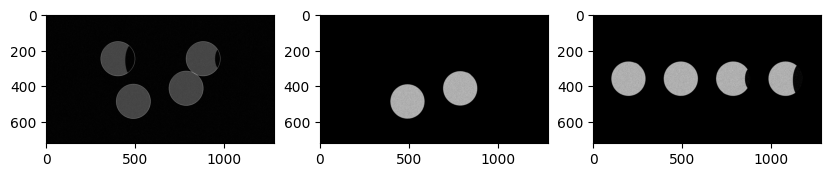

In [15]:
fig , ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(new_image_circles , vmin = 0 , vmax = 255 , cmap =  plt.cm.gray)
ax[1].imshow(new_image_largest , vmin = 0 , vmax = 255 , cmap =  plt.cm.gray)
ax[2].imshow(new_image_sorted , vmin = 0 , vmax = 255 , cmap =  plt.cm.gray)